In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [3]:
# 3

## ImageDataGenerator for input data transformation. ..using rescale in this case (other transformations possible)
## preprocessing (read, pixel-float change, and compress). ..pixels values [0-255] -> compress to [0-1]. ..can use "tf.cast" also for the same purpose

train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

## with flow_from_directory. ..can resize and batch the input data from a spec directory (binary: 2 classes)

train_data_gen = train_image_generator.flow_from_directory(train_dir,target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=batch_size)
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,target_size=(IMG_HEIGHT, IMG_WIDTH), class_mode='binary', batch_size=batch_size)
test_data_gen = test_image_generator.flow_from_directory(PATH,target_size=(IMG_HEIGHT, IMG_WIDTH), classes=['test'], batch_size=batch_size, shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


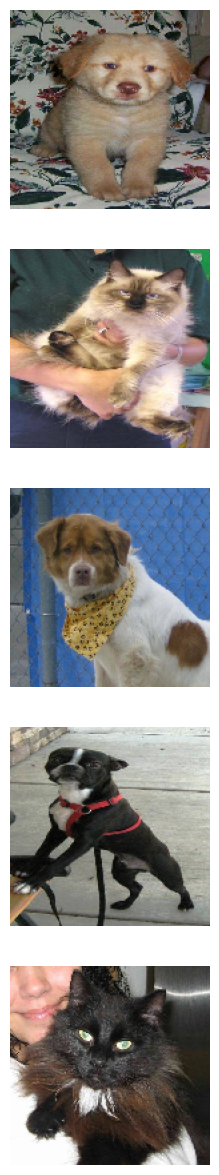

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5

## limited training data, so to avoid overfitting -need to generate more training data by applying transformations to available trainig data

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=30,
                                           zoom_range=0.3,
                                           width_shift_range=0.1,
                                           height_shift_range=0.1)


Found 2000 images belonging to 2 classes.


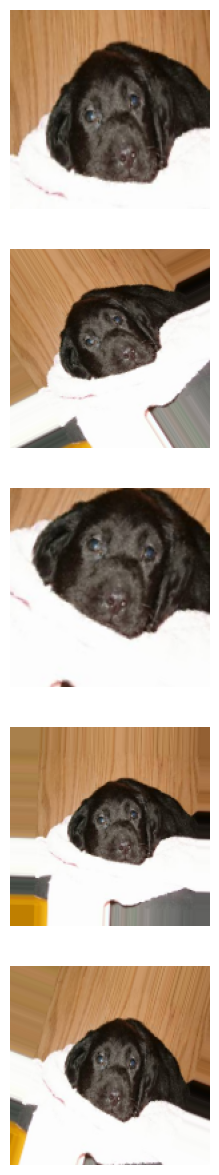

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7

## basic CNN architecture. ..

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_WIDTH,IMG_HEIGHT,3)))   ## padding = 'same' keeps dimensions of output the same as those of input during padding. ..
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))    ## helps prevent overfitting. ..during training randomly sets a fraction (0.5) of input to 0 (and so "dropping" those units). ..helps model to learn wihtout relying too much on spec features
model.add(Dense(1, activation='sigmoid'))   ## only 2 classes, 1 node fine output value between 0 and 1 (sigmoid)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,183,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212,513 (4.63 MB)

 Trainable params: 1,212,513 (4.63 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# 8
epochs = 20

history = model.fit(train_data_gen, validation_data=val_data_gen, batch_size=32, epochs=epochs)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4935 - loss: 0.7460 - val_accuracy: 0.5020 - val_loss: 0.6881
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 870ms/step - accuracy: 0.5364 - loss: 0.6889 - val_accuracy: 0.5150 - val_loss: 0.6789
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 865ms/step - accuracy: 0.5798 - loss: 0.6683 - val_accuracy: 0.6520 - val_loss: 0.6264
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 887ms/step - accuracy: 0.6501 - loss: 0.6313 - val_accuracy: 0.6520 - val_loss: 0.6135
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 891ms/step - accuracy: 0.6458 - loss: 0.6320 - val_accuracy: 0.6770 - val_loss: 0.5975
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 868ms/step - accuracy: 0.6855 - loss: 0.6058 - val_accuracy: 0.6900 - val_loss: 0.5892
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 855ms/step - accuracy: 0.6935 - loss: 0.5898 - val_accuracy: 0.7050 - val_loss: 0.5794
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 881ms/step - accuracy: 0.6762 - loss: 0.6013 - val_accurac

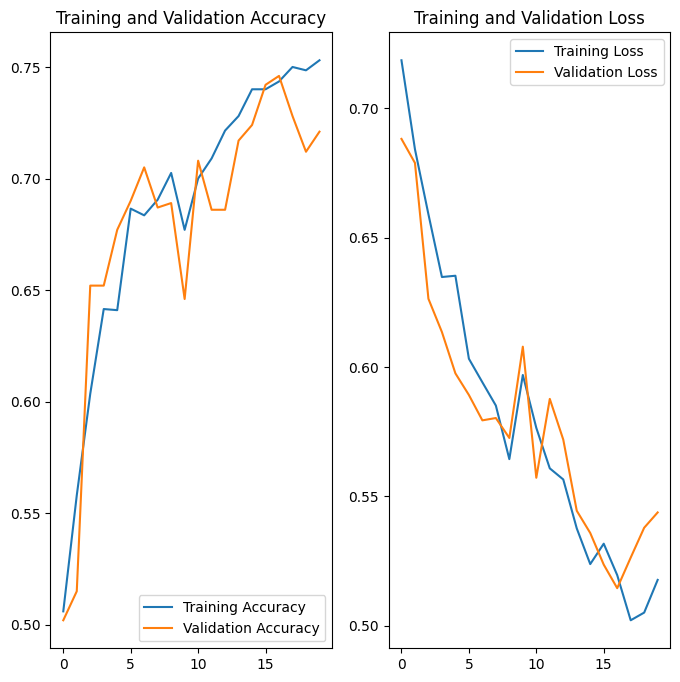

In [9]:
# 9

## visualization of the acc and loss during training and validation to help with how improve model
## first - increase epochs and see visualizations again (target acc ~ 70%)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 956ms/step


/tmp/ipython-input-759011528.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % (probability*100) + "% dog")
/tmp/ipython-input-759011528.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title("%.2f" % ((1-probability)*100) + "% cat")


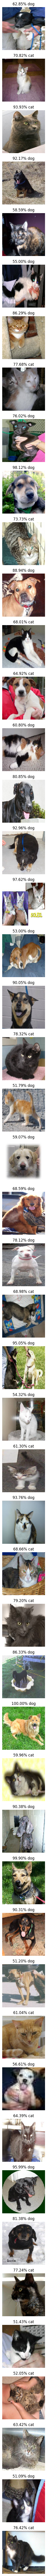

In [10]:
probabilities = model.predict(test_data_gen)
testimages, _ = next(test_data_gen)    ## next - takes next batch of data within spec directory
plotImages(testimages, probabilities)  ## plotImages function created above. ..assumes model outputs probability of dog class
                                       ## if output_prob <50%, classfies cat with (1-output_prob)% probability

In [11]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if np.round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 78.0% of the images of cats and dogs.
You passed the challenge!
